# SDSS DR14 Data Classification with Neural Networks
## Research Question: *How does pre-training (and epochs and batches) affect the performance of a neural network?*

## **Introduction:**
This notebook investigates the impact of pre-training, epochs, and batch sizes on the performance of a neural network model to classify astronomical objects using the SDSS DR14 dataset.
The goal is to predict the 'class' of an object, as ethier a `STAR`, `GALAXY` or `QSO`, based on its features like `ra`, `dec`, `u`, `g`, `r`, `i` and `z`.

- **Dataset:** SDSS DR14
- **Model:** Neural Network (with and without pre-training)
- **Metrics:** Accuracy, Loss

## **Data Loading and Preprocessing**

Imports the necessary libraries for data loading, preprocessing, model building, training, and evaluation.

- **Data Handling**: 
   - `pandas`: Used for data manipulation and analysis.
   - `sklearn.preprocessing`: Provides tools like `LabelEncoder` and `StandardScaler` for data preprocessing.
   - `sklearn.model_selection`: Offers functions like `train_test_split` for splitting the data into training and testing sets.
   
- **PyTorch**:
   - `torch`: The core PyTorch library for building and training models.
   - `torchvision.models`: Includes pre-trained models and utilities for deep learning.
   - `torch.utils.data`: Provides utilities like `TensorDataset` and `DataLoader` for handling data in batches.

- **Neural Network and Optimisation**:
   - `torch.nn`: Contains modules and classes to build neural network layers.
   - `torch.optim`: Provides various optimisation algorithms, including Adam.

- **Model Evaluation**:
   - `sklearn.metrics`: Includes functions like `accuracy_score`, `classification_report`, and `ConfusionMatrixDisplay` for evaluating model performance.
   - `matplotlib.pyplot`: Used for visualising the confusion matrix and other plots.

Using **PyTorch** to create the neural network model can take slightly longer to implement over other modules (e.g: **Tensorflow**), however its more naturally intuitive to use and easier to adapt for different model parameters.

In [42]:
from torchvision.extension import _C
import torchvision
print(torchvision.__file__)

AttributeError: partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)

In [30]:
import pandas as pd                                                 # Import pandas for data manipulation
from sklearn.preprocessing import LabelEncoder, StandardScaler      # Import preprocessing tools
from sklearn.model_selection import train_test_split                # Import train-test split function
import torch                                                        # Import PyTorch for deep learning
import torchvision                       # Import torchvision models for deep learning
from torch.utils.data import TensorDataset, DataLoader              # Import utilities for data loading
import torch.nn as nn                                               # Import PyTorch's neural network module
import torch.optim as optim                                         # Import PyTorch's optimisation module
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay  # Import metrics for model evaluation
import matplotlib.pyplot as plt                                     # Import matplotlib for plotting

AttributeError: partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)


**Steps:**
1. **Data Loading:** The data is loaded from a URL using `pandas.read_csv`. (*You might need to replace the URL with your own link if you're using a different data source*).
2. **Feature and Target Selection:** The relevant features (`ra`, `dec`, `u`, `g`, `r`, `i`, `z`) and the target variable (`class`) are selected.
3. **Target Encoding:** The target labels (star, galaxy, quasar) are encoded using `LabelEncoder` to convert them into numerical values (0, 1 & 2).
4. **Feature Normalization:** Features are normalized using `StandardScaler` to ensure they have zero mean and unit variance. This can improve model training.
5. **Data Splitting:** The data is split into training and testing sets using `train_test_split` with a test size of 20%.
6. **Conversion to PyTorch Tensors:** The training and testing data are converted to PyTorch tensors for use with PyTorch models.
7. **DataLoaders Creation:** `DataLoader` objects are created to efficiently feed data to the model during training and evaluation. The `batch_size` is set to 64, but this can be adjusted later.

In [2]:
# 1. Data Loading: Load the CSV file (replace with your own link if needed)
#data = pd.read_csv("Skyserver_SQL2_27_2018 6_51_39 PM.csv")
url = "https://drive.google.com/uc?id=1Pfii448H__H0qa644YhTKUG68Z8VmxLv"
data = pd.read_csv(url)

# 2. Feature and Target Selection: Select features and target
features = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z']
target = 'class'
X = data[features]
Y = data[target]

# 3. Target Encoding: Encode target labels
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

# 4. Feature Normalization: Normalise features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 5. Data Splitting: Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 6. Conversion to PyTorch Tensors: Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

# 7. DataLoaders Creation: Create DataLoaders
batch_size = 64  # to be varied this later
train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=batch_size, shuffle=False)

## **Model Definition**
**Steps:**
1. **Class Initialization:**
   - The class `SDSSClassifier` is initialized with parameters to configure either a pre-trained ResNet18 model or a custom feedforward network.

2. **Pre-trained ResNet18 (if `pre_trained=True`):**
   - Load a pre-trained ResNet18 model from PyTorch Hub.
   - Modify its fully connected (`fc`) layer to match the required output dimension.
   - Add a reshape layer to transform input features into a format compatible with ResNet18.

3. **Custom Feedforward Network (if `pre_trained=False`):**
   - Define a simple architecture with two linear layers and a ReLU activation function for non-linearity.

4. **Forward Method:**
   - If using the pre-trained model, reshape the input and pass it through ResNet18.
   - If using the custom model, directly pass the input through the defined feedforward layers.



In [3]:
class SDSSClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, pre_trained=False):
        # 1. Initialises the SDSSClassifier model.
        """
        Args:
            input_dim (int): Number of input features.
            hidden_dim (int): Number of units in the hidden layer for the custom model.
            output_dim (int): Number of output classes.
            pre_trained (bool): Whether to use a pre-trained model (e.g., ResNet18). Defaults to False.
        """
        super(SDSSClassifier, self).__init__()
        self.pre_trained = pre_trained

        if pre_trained:
            # 2. Use a pre-trained ResNet18 model for feature extraction
            self.features = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

            # 2. Use a pre-trained ResNet18 model for feature extraction
            #self.features = models.resnet50(pretrained=True)

            # Modify the final fully connected layer to match the required output dimension
            num_ftrs = self.features.fc.in_features
            self.features.fc = nn.Linear(num_ftrs, output_dim)

            # Add a reshape layer to transform the input into a format compatible with ResNet18
            self.reshape_layer = nn.Sequential(
                nn.Linear(input_dim, 224*224*3),  # Flatten input and match ResNet18's input size
                nn.Unflatten(1, (3, 224, 224))   # Reshape to [channels, height, width]
            )

        else:
            # 3. Define a custom feedforward neural network
            self.fc = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),  # Fully connected layer
                nn.ReLU(),                         # ReLU activation for non-linearity
                nn.Linear(hidden_dim, output_dim)  # Output layer with the desired number of classes
            )

    def forward(self, x):
        # 4. Defines the forward pass of the model.
        """
        Args:
            x (torch.Tensor): Input data tensor.

        Returns:
            torch.Tensor: Output predictions.
        """
        if self.pre_trained:
            # Reshape input for the pre-trained ResNet18 model
            x = self.reshape_layer(x)
            return self.features(x)  # Forward pass through ResNet18
        else:
            # Forward pass through the custom feedforward network
            return self.fc(x)


## **Training and Evaluation**
**Steps:**

### For `evaluate` Function:

1. **Model Evaluation Mode:** The function starts by setting the model to evaluation mode (`model.eval()`), which disables dropout and batch normalization layers for inference.
2. **Initialization:** Two lists, `all_preds` and `all_labels`, are initialized to store predictions and true labels respectively.
3. **Inference Without Gradient Tracking:**
   - A `torch.no_grad()` block is used to disable gradient computation, improving performance during evaluation.
4. **Batch-Wise Prediction:**
   - For each batch in the `data_loader`, inputs are passed through the model to obtain outputs.
   - The `torch.max` function is used to get the predicted class for each input.
   - Predictions and labels are collected in their respective lists.
5. **Accuracy Calculation:**
   - The `accuracy_score` function is used to compute accuracy by comparing all predictions (`all_preds`) with true labels (`all_labels`).

---

### For `train_and_evaluate` Function:

1. **Loss and Optimizer Initialization:**
   - The loss function is set to `CrossEntropyLoss` (suitable for classification tasks).
   - The optimizer is set to `Adam` with a learning rate of `0.001`.
2. **Tracking Metrics:**
   - Lists `train_losses` and `train_accuracies` are initialized to store per-epoch metrics.
3. **Training Loop:**
   - The model is set to training mode (`model.train()`).
   - Per-epoch, the training accuracy is calculated using the `evaluate` function and stored in `train_accuracies`.
   - The loss is calculated and accumulated for each batch, and the optimizer updates the model parameters.
   - Average loss for the epoch is computed and printed.
4. **Evaluation After Training:**
   - After training, the model is set to evaluation mode to predict on the test dataset.
   - Predictions and true labels are collected across all batches, and accuracy is calculated using `accuracy_score`.
   - A classification report and confusion matrix are generated to summarize the model’s performance.
5. **Accuracy Calculation:**
   - The `accuracy_score` function is used to compute accuracy by comparing all predictions (`all_preds`) with true labels (`all_labels`).
6. **Visualization:**
   - A confusion matrix is displayed with labels and a descriptive title showing key training parameters.


In [4]:
def evaluate(model, data_loader):
    # 1. Define the evaluate function.
    """
    This function evaluates the model's performance on a dataset.

    Args:
        model (torch.nn.Module): The trained model.
        data_loader (DataLoader): DataLoader for the dataset to evaluate.

    Returns:
        float: Accuracy of the model on the given dataset.
    """
    model.eval()  # 1. Set model to evaluation mode
    all_preds = []  # 2. Initialise list to store predictions
    all_labels = []  # 2. Initialise list to store true labels

    with torch.no_grad():  # 3. Disable gradient computation for evaluation
        for inputs, labels in data_loader:  # 4. Iterate through batches
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get predicted classes
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    # 5. Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

def train_and_evaluate(model, train_loader, test_loader, num_epochs, learning_rate=0.001):
    # 1. Define the training and evaluation function.
    """
    This function trains the model and evaluates its performance on the test set.

    Args:
        model (torch.nn.Module): The model to train and evaluate.
        train_loader (DataLoader): DataLoader for the training data.
        test_loader (DataLoader): DataLoader for the test data.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for the optimizer. Defaults to 0.001.

    Returns:
        tuple: Final test accuracy, training losses, and training accuracies.
    """
    criterion = nn.CrossEntropyLoss()  # 1. Define the loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # 1. Define the optimizer

    train_losses = []  # 2. Initialise list to track training losses
    train_accuracies = []  # 2. Initialise list to track training accuracies

    for epoch in range(num_epochs):  # 3. Training loop
        model.train()  # Set model to training mode
        total_loss = 0

        train_accuracy = evaluate(model, train_loader)  # Calculate training accuracy for the epoch
        train_accuracies.append(train_accuracy)
        # 3. Batch-wise training
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))  # Store average loss for the epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")
    # 4. Evaluate test data
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    # 5. Compute test accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.2f}")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

    # 6. Create and display confusion matrix
    title = f"Confusion Matrix (Pre-trained={pre_trained}, Epochs={num_epochs}, Batch Size={batch_size})"  # Create title
    cm = ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, display_labels=label_encoder.classes_)
    plt.title(title)  # Set the title
    plt.show()
    return accuracy, train_losses, train_accuracies # Return results


## **Experimentation**
**Steps:**

1. **Experiment Setup:** Define different configurations for experiments. This includes options for whether to use a pre-trained model, the number of epochs, and the batch size. These are stored in the lists `pre_trained_options`, `epoch_options`, and `batch_size_options`.

2. **Initialization of Results Storage:** Create an empty list `results` to store the outcomes of all the experiments.

3. **Nested Loop for Experiment Combinations:**
   - A nested loop is used to iterate over all possible combinations of the settings for pre-training, epochs, and batch size.
   - The experiment settings are printed for each iteration.

4. **DataLoader Creation:**
   - For each combination of settings, `DataLoader` objects are created using the training and test tensors (`X_train_tensor`, `Y_train_tensor`, `X_test_tensor`, `Y_test_tensor`).
   - The batch size is adjusted according to the current experiment setting, and the `shuffle=True` option ensures random sampling of the training data.

5. **Model Instantiation:**
   - The input dimension is derived from the training data shape.
   - The hidden layer dimension is set to 64 (this can be adjusted if needed).
   - The output dimension corresponds to the number of classes in the label encoder.
   - A new model (`SDSSClassifier`) is instantiated with the current configuration (`pre_trained` setting).

6. **Training and Evaluation:**
   - The `train_and_evaluate` function is called to train the model and evaluate its performance on the test set for the given number of epochs.
   - The function returns the final accuracy, training losses, and training accuracies.

7. **Model Saving:** After training, the model's state dictionary (the learned parameters) is saved using `torch.save`. The file is named according to the experiment configuration (`pre_trained`, `num_epochs`, `batch_size`).

8. **Recording Results:**
   - After each experiment, the results (accuracy, training losses, and training accuracies) are appended to the `results` list for further analysis.


Running experiment: Pre-trained=False, Epochs=5, Batch Size=32
Epoch 1/5, Loss: 0.7424, Train Accuracy: 0.2529
Epoch 2/5, Loss: 0.5492, Train Accuracy: 0.7644
Epoch 3/5, Loss: 0.4745, Train Accuracy: 0.8009
Epoch 4/5, Loss: 0.4128, Train Accuracy: 0.8429
Epoch 5/5, Loss: 0.3630, Train Accuracy: 0.8759
Accuracy: 0.90
              precision    recall  f1-score   support

      GALAXY       0.92      0.89      0.91       996
         QSO       0.90      0.85      0.87       190
        STAR       0.86      0.91      0.89       814

    accuracy                           0.90      2000
   macro avg       0.90      0.88      0.89      2000
weighted avg       0.90      0.90      0.90      2000



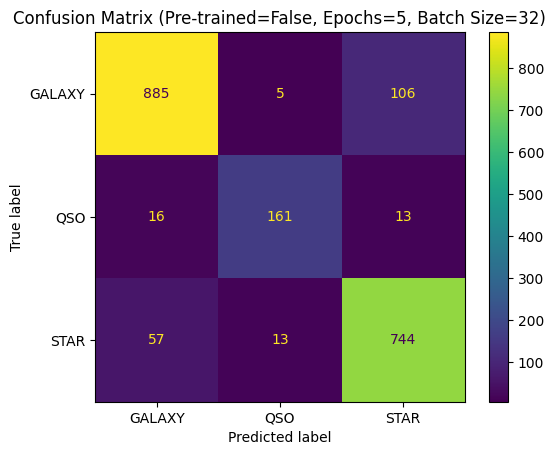

Running experiment: Pre-trained=False, Epochs=5, Batch Size=64
Epoch 1/5, Loss: 0.8219, Train Accuracy: 0.3544
Epoch 2/5, Loss: 0.5913, Train Accuracy: 0.7578
Epoch 3/5, Loss: 0.5200, Train Accuracy: 0.7816
Epoch 4/5, Loss: 0.4671, Train Accuracy: 0.8055
Epoch 5/5, Loss: 0.4213, Train Accuracy: 0.8344
Accuracy: 0.86
              precision    recall  f1-score   support

      GALAXY       0.91      0.85      0.88       996
         QSO       0.88      0.82      0.85       190
        STAR       0.81      0.89      0.85       814

    accuracy                           0.86      2000
   macro avg       0.87      0.85      0.86      2000
weighted avg       0.86      0.86      0.86      2000



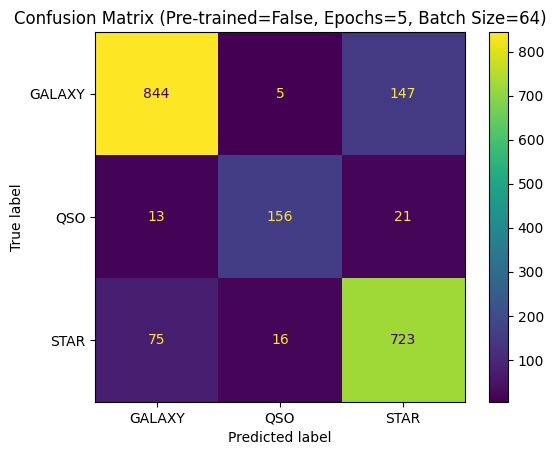

Running experiment: Pre-trained=False, Epochs=5, Batch Size=128
Epoch 1/5, Loss: 0.9727, Train Accuracy: 0.0825
Epoch 2/5, Loss: 0.7154, Train Accuracy: 0.6940
Epoch 3/5, Loss: 0.6266, Train Accuracy: 0.7275
Epoch 4/5, Loss: 0.5797, Train Accuracy: 0.7585
Epoch 5/5, Loss: 0.5454, Train Accuracy: 0.7704
Accuracy: 0.78
              precision    recall  f1-score   support

      GALAXY       0.82      0.81      0.82       996
         QSO       0.83      0.71      0.76       190
        STAR       0.73      0.77      0.75       814

    accuracy                           0.78      2000
   macro avg       0.79      0.76      0.78      2000
weighted avg       0.79      0.78      0.78      2000



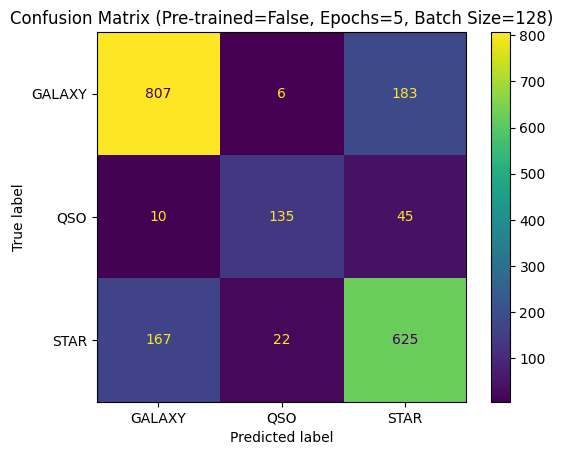

Running experiment: Pre-trained=False, Epochs=10, Batch Size=32
Epoch 1/10, Loss: 0.7679, Train Accuracy: 0.1951
Epoch 2/10, Loss: 0.5608, Train Accuracy: 0.7292
Epoch 3/10, Loss: 0.4841, Train Accuracy: 0.7920
Epoch 4/10, Loss: 0.4189, Train Accuracy: 0.8344
Epoch 5/10, Loss: 0.3703, Train Accuracy: 0.8750
Epoch 6/10, Loss: 0.3355, Train Accuracy: 0.9028
Epoch 7/10, Loss: 0.3131, Train Accuracy: 0.9110
Epoch 8/10, Loss: 0.2987, Train Accuracy: 0.9114
Epoch 9/10, Loss: 0.2882, Train Accuracy: 0.9201
Epoch 10/10, Loss: 0.2809, Train Accuracy: 0.9225
Accuracy: 0.92
              precision    recall  f1-score   support

      GALAXY       0.95      0.91      0.93       996
         QSO       0.92      0.91      0.91       190
        STAR       0.89      0.95      0.92       814

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.93      0.92      0.92      2000



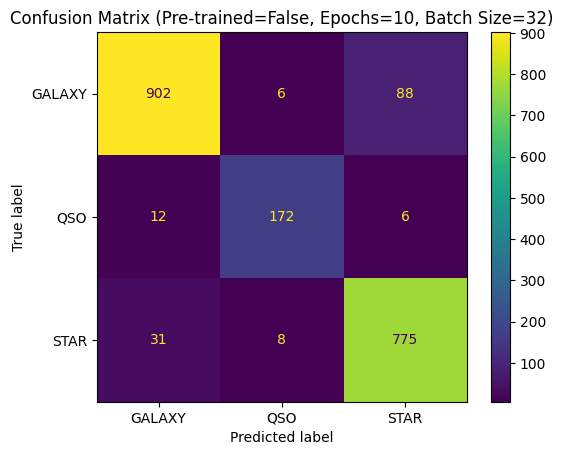

Running experiment: Pre-trained=False, Epochs=10, Batch Size=64
Epoch 1/10, Loss: 0.8180, Train Accuracy: 0.3684
Epoch 2/10, Loss: 0.6127, Train Accuracy: 0.7385
Epoch 3/10, Loss: 0.5500, Train Accuracy: 0.7649
Epoch 4/10, Loss: 0.5047, Train Accuracy: 0.7856
Epoch 5/10, Loss: 0.4609, Train Accuracy: 0.8117
Epoch 6/10, Loss: 0.4181, Train Accuracy: 0.8419
Epoch 7/10, Loss: 0.3807, Train Accuracy: 0.8698
Epoch 8/10, Loss: 0.3523, Train Accuracy: 0.8855
Epoch 9/10, Loss: 0.3307, Train Accuracy: 0.9006
Epoch 10/10, Loss: 0.3151, Train Accuracy: 0.9125
Accuracy: 0.91
              precision    recall  f1-score   support

      GALAXY       0.95      0.89      0.92       996
         QSO       0.94      0.84      0.89       190
        STAR       0.87      0.96      0.91       814

    accuracy                           0.91      2000
   macro avg       0.92      0.90      0.90      2000
weighted avg       0.92      0.91      0.91      2000



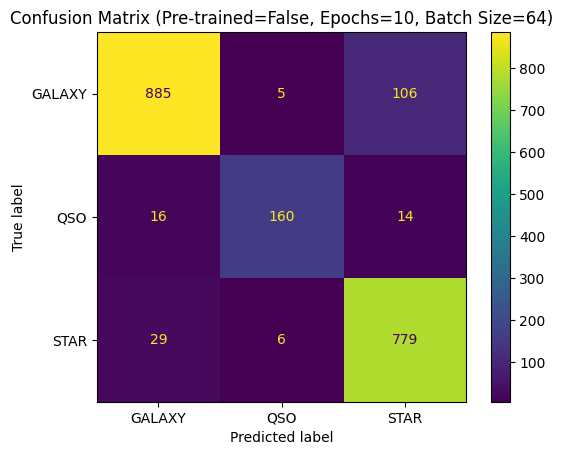

Running experiment: Pre-trained=False, Epochs=10, Batch Size=128
Epoch 1/10, Loss: 0.9551, Train Accuracy: 0.3441
Epoch 2/10, Loss: 0.7335, Train Accuracy: 0.6879
Epoch 3/10, Loss: 0.6333, Train Accuracy: 0.7404
Epoch 4/10, Loss: 0.5812, Train Accuracy: 0.7539
Epoch 5/10, Loss: 0.5437, Train Accuracy: 0.7736
Epoch 6/10, Loss: 0.5100, Train Accuracy: 0.7847
Epoch 7/10, Loss: 0.4787, Train Accuracy: 0.8065
Epoch 8/10, Loss: 0.4504, Train Accuracy: 0.8226
Epoch 9/10, Loss: 0.4224, Train Accuracy: 0.8464
Epoch 10/10, Loss: 0.3957, Train Accuracy: 0.8636
Accuracy: 0.87
              precision    recall  f1-score   support

      GALAXY       0.91      0.87      0.89       996
         QSO       0.89      0.85      0.87       190
        STAR       0.84      0.89      0.86       814

    accuracy                           0.87      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.88      0.87      0.87      2000



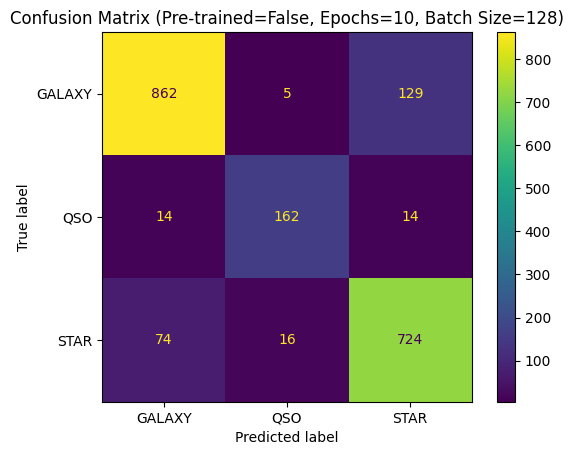

Running experiment: Pre-trained=False, Epochs=20, Batch Size=32
Epoch 1/20, Loss: 0.7030, Train Accuracy: 0.3498
Epoch 2/20, Loss: 0.5222, Train Accuracy: 0.7711
Epoch 3/20, Loss: 0.4447, Train Accuracy: 0.8125
Epoch 4/20, Loss: 0.3812, Train Accuracy: 0.8599
Epoch 5/20, Loss: 0.3387, Train Accuracy: 0.8941
Epoch 6/20, Loss: 0.3147, Train Accuracy: 0.9100
Epoch 7/20, Loss: 0.2981, Train Accuracy: 0.9165
Epoch 8/20, Loss: 0.2882, Train Accuracy: 0.9250
Epoch 9/20, Loss: 0.2809, Train Accuracy: 0.9269
Epoch 10/20, Loss: 0.2775, Train Accuracy: 0.9286
Epoch 11/20, Loss: 0.2723, Train Accuracy: 0.9343
Epoch 12/20, Loss: 0.2693, Train Accuracy: 0.9336
Epoch 13/20, Loss: 0.2659, Train Accuracy: 0.9339
Epoch 14/20, Loss: 0.2641, Train Accuracy: 0.9371
Epoch 15/20, Loss: 0.2608, Train Accuracy: 0.9371
Epoch 16/20, Loss: 0.2589, Train Accuracy: 0.9366
Epoch 17/20, Loss: 0.2572, Train Accuracy: 0.9373
Epoch 18/20, Loss: 0.2550, Train Accuracy: 0.9417
Epoch 19/20, Loss: 0.2530, Train Accuracy: 0.

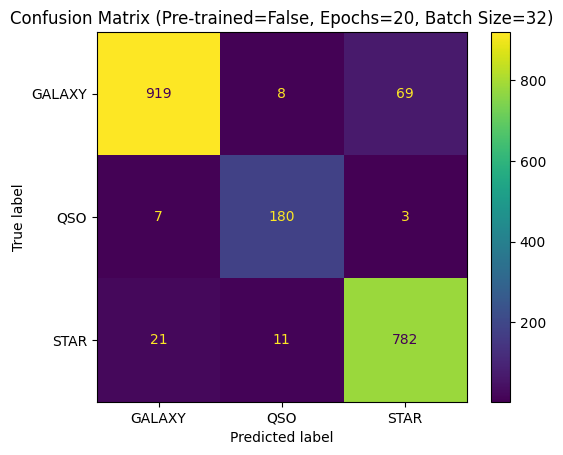

Running experiment: Pre-trained=False, Epochs=20, Batch Size=64
Epoch 1/20, Loss: 0.8128, Train Accuracy: 0.3078
Epoch 2/20, Loss: 0.6217, Train Accuracy: 0.7221
Epoch 3/20, Loss: 0.5620, Train Accuracy: 0.7529
Epoch 4/20, Loss: 0.5179, Train Accuracy: 0.7694
Epoch 5/20, Loss: 0.4705, Train Accuracy: 0.8033
Epoch 6/20, Loss: 0.4245, Train Accuracy: 0.8404
Epoch 7/20, Loss: 0.3867, Train Accuracy: 0.8676
Epoch 8/20, Loss: 0.3568, Train Accuracy: 0.8835
Epoch 9/20, Loss: 0.3352, Train Accuracy: 0.8976
Epoch 10/20, Loss: 0.3192, Train Accuracy: 0.9073
Epoch 11/20, Loss: 0.3081, Train Accuracy: 0.9135
Epoch 12/20, Loss: 0.2993, Train Accuracy: 0.9167
Epoch 13/20, Loss: 0.2919, Train Accuracy: 0.9199
Epoch 14/20, Loss: 0.2865, Train Accuracy: 0.9225
Epoch 15/20, Loss: 0.2814, Train Accuracy: 0.9234
Epoch 16/20, Loss: 0.2784, Train Accuracy: 0.9260
Epoch 17/20, Loss: 0.2749, Train Accuracy: 0.9300
Epoch 18/20, Loss: 0.2726, Train Accuracy: 0.9275
Epoch 19/20, Loss: 0.2707, Train Accuracy: 0.

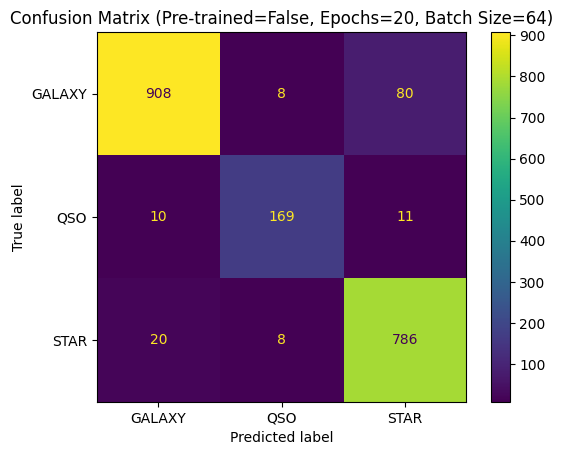

Running experiment: Pre-trained=False, Epochs=20, Batch Size=128
Epoch 1/20, Loss: 0.8860, Train Accuracy: 0.4635
Epoch 2/20, Loss: 0.6915, Train Accuracy: 0.7049
Epoch 3/20, Loss: 0.6090, Train Accuracy: 0.7559
Epoch 4/20, Loss: 0.5623, Train Accuracy: 0.7672
Epoch 5/20, Loss: 0.5268, Train Accuracy: 0.7805
Epoch 6/20, Loss: 0.4950, Train Accuracy: 0.7969
Epoch 7/20, Loss: 0.4647, Train Accuracy: 0.8209
Epoch 8/20, Loss: 0.4328, Train Accuracy: 0.8371
Epoch 9/20, Loss: 0.4057, Train Accuracy: 0.8584
Epoch 10/20, Loss: 0.3826, Train Accuracy: 0.8756
Epoch 11/20, Loss: 0.3624, Train Accuracy: 0.8850
Epoch 12/20, Loss: 0.3483, Train Accuracy: 0.8960
Epoch 13/20, Loss: 0.3345, Train Accuracy: 0.9032
Epoch 14/20, Loss: 0.3226, Train Accuracy: 0.9075
Epoch 15/20, Loss: 0.3139, Train Accuracy: 0.9166
Epoch 16/20, Loss: 0.3065, Train Accuracy: 0.9185
Epoch 17/20, Loss: 0.3001, Train Accuracy: 0.9207
Epoch 18/20, Loss: 0.2944, Train Accuracy: 0.9247
Epoch 19/20, Loss: 0.2902, Train Accuracy: 0

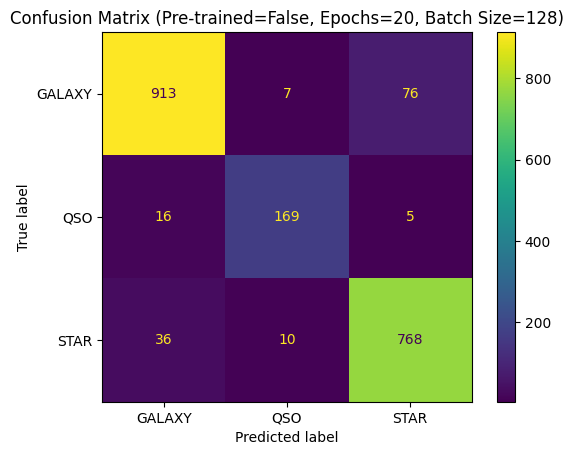

Running experiment: Pre-trained=True, Epochs=5, Batch Size=32
Epoch 1/5, Loss: 0.7355, Train Accuracy: 0.4109
Epoch 2/5, Loss: 0.5529, Train Accuracy: 0.7556
Epoch 3/5, Loss: 0.4877, Train Accuracy: 0.7931
Epoch 4/5, Loss: 0.4299, Train Accuracy: 0.8217
Epoch 5/5, Loss: 0.3793, Train Accuracy: 0.8674
Accuracy: 0.89
              precision    recall  f1-score   support

      GALAXY       0.92      0.88      0.90       996
         QSO       0.90      0.84      0.87       190
        STAR       0.85      0.91      0.88       814

    accuracy                           0.89      2000
   macro avg       0.89      0.88      0.88      2000
weighted avg       0.89      0.89      0.89      2000



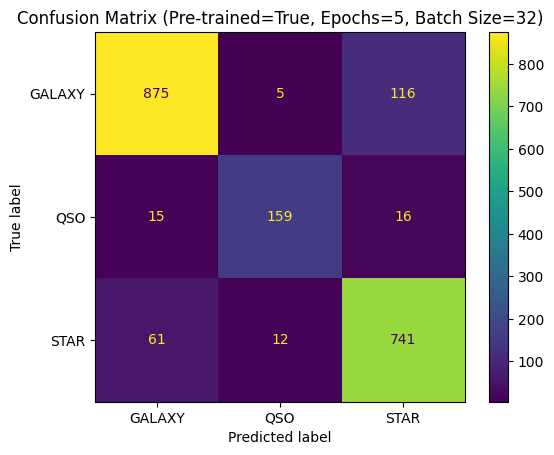

Running experiment: Pre-trained=True, Epochs=5, Batch Size=64
Epoch 1/5, Loss: 0.8069, Train Accuracy: 0.5430
Epoch 2/5, Loss: 0.6218, Train Accuracy: 0.7265
Epoch 3/5, Loss: 0.5528, Train Accuracy: 0.7612
Epoch 4/5, Loss: 0.4990, Train Accuracy: 0.7915
Epoch 5/5, Loss: 0.4472, Train Accuracy: 0.8224
Accuracy: 0.85
              precision    recall  f1-score   support

      GALAXY       0.89      0.84      0.86       996
         QSO       0.86      0.79      0.83       190
        STAR       0.80      0.86      0.83       814

    accuracy                           0.85      2000
   macro avg       0.85      0.83      0.84      2000
weighted avg       0.85      0.85      0.85      2000



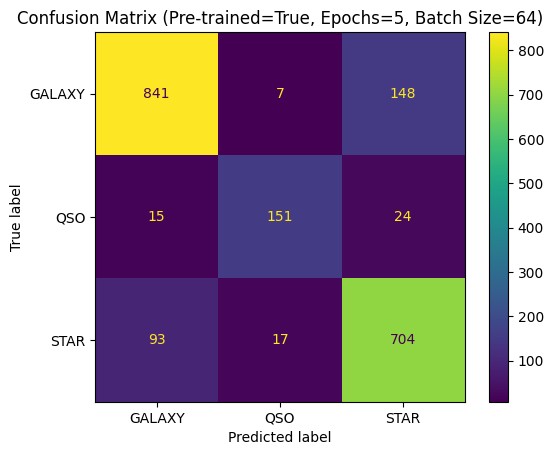

Running experiment: Pre-trained=True, Epochs=5, Batch Size=128
Epoch 1/5, Loss: 0.9375, Train Accuracy: 0.1207
Epoch 2/5, Loss: 0.7254, Train Accuracy: 0.6975
Epoch 3/5, Loss: 0.6316, Train Accuracy: 0.7525
Epoch 4/5, Loss: 0.5795, Train Accuracy: 0.7665
Epoch 5/5, Loss: 0.5434, Train Accuracy: 0.7794
Accuracy: 0.78
              precision    recall  f1-score   support

      GALAXY       0.82      0.81      0.82       996
         QSO       0.84      0.69      0.76       190
        STAR       0.73      0.77      0.75       814

    accuracy                           0.78      2000
   macro avg       0.80      0.76      0.77      2000
weighted avg       0.79      0.78      0.78      2000



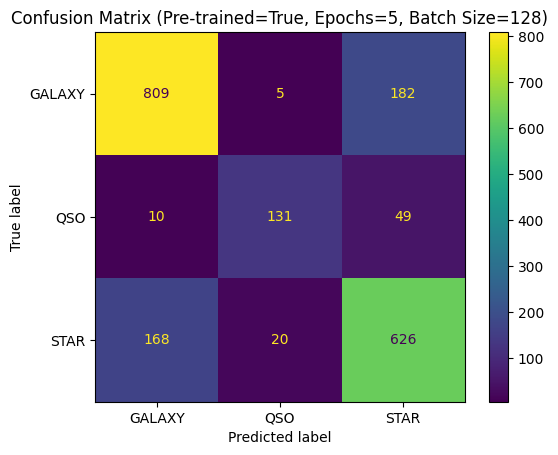

Running experiment: Pre-trained=True, Epochs=10, Batch Size=32
Epoch 1/10, Loss: 0.7558, Train Accuracy: 0.1603
Epoch 2/10, Loss: 0.5569, Train Accuracy: 0.7639
Epoch 3/10, Loss: 0.4866, Train Accuracy: 0.7960
Epoch 4/10, Loss: 0.4243, Train Accuracy: 0.8250
Epoch 5/10, Loss: 0.3730, Train Accuracy: 0.8670
Epoch 6/10, Loss: 0.3380, Train Accuracy: 0.8929
Epoch 7/10, Loss: 0.3165, Train Accuracy: 0.9079
Epoch 8/10, Loss: 0.3024, Train Accuracy: 0.9150
Epoch 9/10, Loss: 0.2923, Train Accuracy: 0.9167
Epoch 10/10, Loss: 0.2859, Train Accuracy: 0.9206
Accuracy: 0.92
              precision    recall  f1-score   support

      GALAXY       0.95      0.91      0.93       996
         QSO       0.91      0.91      0.91       190
        STAR       0.90      0.95      0.92       814

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.93      0.92      0.92      2000



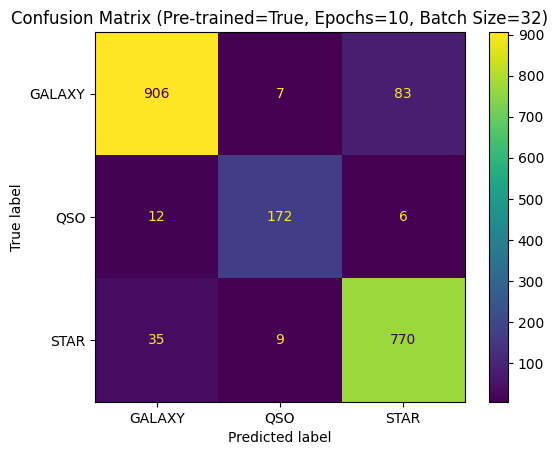

Running experiment: Pre-trained=True, Epochs=10, Batch Size=64
Epoch 1/10, Loss: 0.8689, Train Accuracy: 0.1799
Epoch 2/10, Loss: 0.6198, Train Accuracy: 0.7412
Epoch 3/10, Loss: 0.5569, Train Accuracy: 0.7598
Epoch 4/10, Loss: 0.5135, Train Accuracy: 0.7812
Epoch 5/10, Loss: 0.4674, Train Accuracy: 0.8071
Epoch 6/10, Loss: 0.4213, Train Accuracy: 0.8399
Epoch 7/10, Loss: 0.3839, Train Accuracy: 0.8672
Epoch 8/10, Loss: 0.3537, Train Accuracy: 0.8801
Epoch 9/10, Loss: 0.3310, Train Accuracy: 0.8989
Epoch 10/10, Loss: 0.3157, Train Accuracy: 0.9104
Accuracy: 0.92
              precision    recall  f1-score   support

      GALAXY       0.95      0.90      0.93       996
         QSO       0.92      0.83      0.87       190
        STAR       0.88      0.95      0.91       814

    accuracy                           0.92      2000
   macro avg       0.92      0.90      0.90      2000
weighted avg       0.92      0.92      0.92      2000



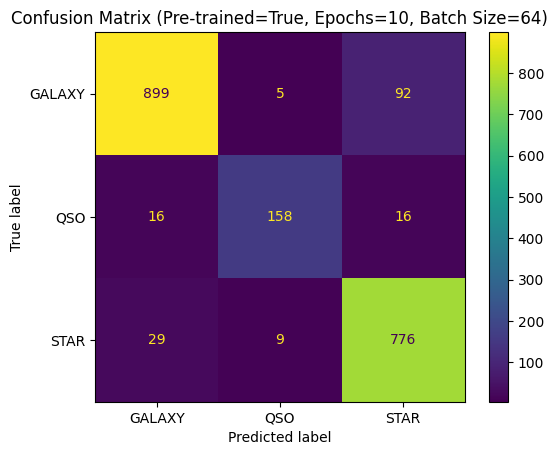

Running experiment: Pre-trained=True, Epochs=10, Batch Size=128
Epoch 1/10, Loss: 0.8976, Train Accuracy: 0.4054
Epoch 2/10, Loss: 0.7071, Train Accuracy: 0.7019
Epoch 3/10, Loss: 0.6265, Train Accuracy: 0.7466
Epoch 4/10, Loss: 0.5849, Train Accuracy: 0.7618
Epoch 5/10, Loss: 0.5532, Train Accuracy: 0.7639
Epoch 6/10, Loss: 0.5255, Train Accuracy: 0.7791
Epoch 7/10, Loss: 0.4987, Train Accuracy: 0.7926
Epoch 8/10, Loss: 0.4700, Train Accuracy: 0.8080
Epoch 9/10, Loss: 0.4465, Train Accuracy: 0.8293
Epoch 10/10, Loss: 0.4166, Train Accuracy: 0.8478
Accuracy: 0.87
              precision    recall  f1-score   support

      GALAXY       0.91      0.86      0.88       996
         QSO       0.87      0.81      0.84       190
        STAR       0.82      0.89      0.86       814

    accuracy                           0.87      2000
   macro avg       0.87      0.85      0.86      2000
weighted avg       0.87      0.87      0.87      2000



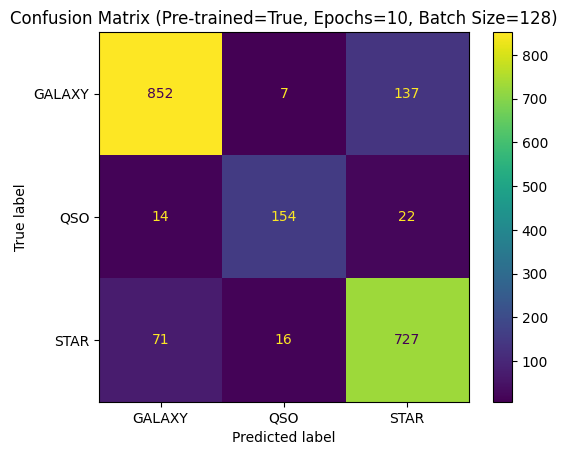

Running experiment: Pre-trained=True, Epochs=20, Batch Size=32
Epoch 1/20, Loss: 0.7558, Train Accuracy: 0.2442
Epoch 2/20, Loss: 0.5646, Train Accuracy: 0.7452
Epoch 3/20, Loss: 0.4883, Train Accuracy: 0.7864
Epoch 4/20, Loss: 0.4205, Train Accuracy: 0.8355
Epoch 5/20, Loss: 0.3708, Train Accuracy: 0.8694
Epoch 6/20, Loss: 0.3365, Train Accuracy: 0.8938
Epoch 7/20, Loss: 0.3136, Train Accuracy: 0.9097
Epoch 8/20, Loss: 0.2993, Train Accuracy: 0.9177
Epoch 9/20, Loss: 0.2891, Train Accuracy: 0.9254
Epoch 10/20, Loss: 0.2818, Train Accuracy: 0.9261
Epoch 11/20, Loss: 0.2769, Train Accuracy: 0.9300
Epoch 12/20, Loss: 0.2718, Train Accuracy: 0.9287
Epoch 13/20, Loss: 0.2693, Train Accuracy: 0.9309
Epoch 14/20, Loss: 0.2663, Train Accuracy: 0.9323
Epoch 15/20, Loss: 0.2642, Train Accuracy: 0.9343
Epoch 16/20, Loss: 0.2614, Train Accuracy: 0.9335
Epoch 17/20, Loss: 0.2591, Train Accuracy: 0.9351
Epoch 18/20, Loss: 0.2582, Train Accuracy: 0.9327
Epoch 19/20, Loss: 0.2556, Train Accuracy: 0.9

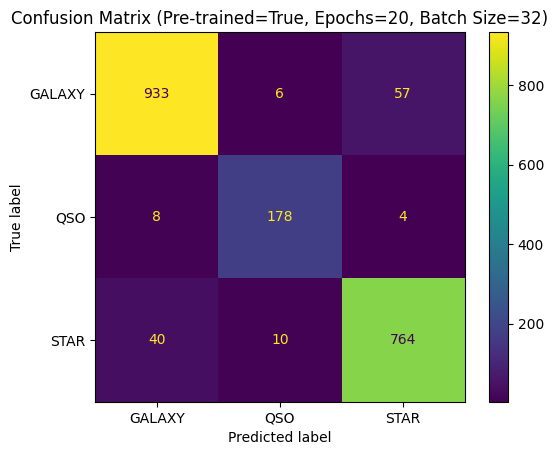

Running experiment: Pre-trained=True, Epochs=20, Batch Size=64
Epoch 1/20, Loss: 0.8250, Train Accuracy: 0.3177
Epoch 2/20, Loss: 0.6177, Train Accuracy: 0.7285
Epoch 3/20, Loss: 0.5575, Train Accuracy: 0.7622
Epoch 4/20, Loss: 0.5141, Train Accuracy: 0.7859
Epoch 5/20, Loss: 0.4711, Train Accuracy: 0.8093
Epoch 6/20, Loss: 0.4297, Train Accuracy: 0.8345
Epoch 7/20, Loss: 0.3935, Train Accuracy: 0.8622
Epoch 8/20, Loss: 0.3648, Train Accuracy: 0.8841
Epoch 9/20, Loss: 0.3428, Train Accuracy: 0.8968
Epoch 10/20, Loss: 0.3250, Train Accuracy: 0.9084
Epoch 11/20, Loss: 0.3119, Train Accuracy: 0.9140
Epoch 12/20, Loss: 0.3019, Train Accuracy: 0.9201
Epoch 13/20, Loss: 0.2929, Train Accuracy: 0.9230
Epoch 14/20, Loss: 0.2873, Train Accuracy: 0.9261
Epoch 15/20, Loss: 0.2812, Train Accuracy: 0.9293
Epoch 16/20, Loss: 0.2769, Train Accuracy: 0.9287
Epoch 17/20, Loss: 0.2729, Train Accuracy: 0.9306
Epoch 18/20, Loss: 0.2698, Train Accuracy: 0.9313
Epoch 19/20, Loss: 0.2672, Train Accuracy: 0.9

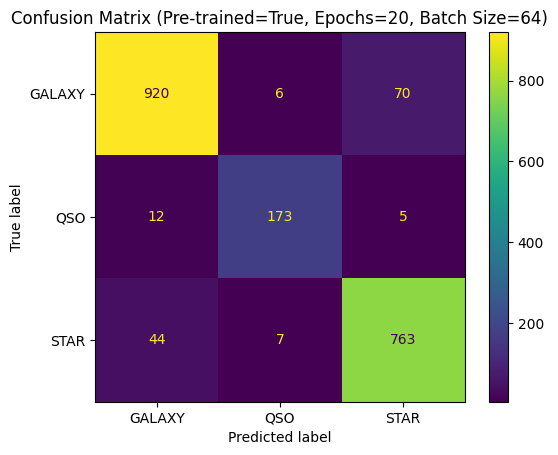

Running experiment: Pre-trained=True, Epochs=20, Batch Size=128
Epoch 1/20, Loss: 0.9136, Train Accuracy: 0.3839
Epoch 2/20, Loss: 0.7015, Train Accuracy: 0.7037
Epoch 3/20, Loss: 0.6194, Train Accuracy: 0.7344
Epoch 4/20, Loss: 0.5792, Train Accuracy: 0.7515
Epoch 5/20, Loss: 0.5475, Train Accuracy: 0.7685
Epoch 6/20, Loss: 0.5180, Train Accuracy: 0.7836
Epoch 7/20, Loss: 0.4873, Train Accuracy: 0.7979
Epoch 8/20, Loss: 0.4580, Train Accuracy: 0.8200
Epoch 9/20, Loss: 0.4266, Train Accuracy: 0.8373
Epoch 10/20, Loss: 0.3977, Train Accuracy: 0.8572
Epoch 11/20, Loss: 0.3732, Train Accuracy: 0.8770
Epoch 12/20, Loss: 0.3560, Train Accuracy: 0.8836
Epoch 13/20, Loss: 0.3415, Train Accuracy: 0.8970
Epoch 14/20, Loss: 0.3303, Train Accuracy: 0.9050
Epoch 15/20, Loss: 0.3197, Train Accuracy: 0.9127
Epoch 16/20, Loss: 0.3123, Train Accuracy: 0.9173
Epoch 17/20, Loss: 0.3060, Train Accuracy: 0.9195
Epoch 18/20, Loss: 0.2975, Train Accuracy: 0.9180
Epoch 19/20, Loss: 0.2943, Train Accuracy: 0.

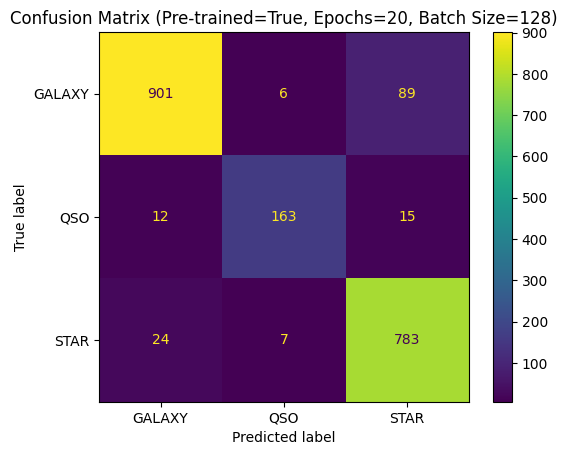

In [15]:
# 1. Experiment with different settings
pre_trained_options = [False, True]  # Define pre-training options: with and without pre-training
epoch_options = [5, 10, 20]  # Define different numbers of training epochs
batch_size_options = [32, 64, 128]  # Define batch size options

results = []  # 2. Initialise a list to store experiment results

# 3. Nested loops for experiments with all combinations of settings
for pre_trained in pre_trained_options:
    for num_epochs in epoch_options:
        for batch_size in batch_size_options:
            print(f"Running experiment: Pre-trained={pre_trained}, Epochs={num_epochs}, Batch Size={batch_size}")

            # 4. Create DataLoader with current batch size
            train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=batch_size, shuffle=False)

            # 5. Instantiate and configure the model
            input_dim = X_train.shape[1]  # Input dimension from dataset
            hidden_dim = 64  # Hidden layer size (adjustable)
            output_dim = len(label_encoder.classes_)  # Number of output classes
            ###model = SDSSClassifier(input_dim, hidden_dim, output_dim, pre_trained=False)  # Create the model
            model = SDSSClassifier(input_dim, hidden_dim, output_dim, pre_trained=pre_trained)  # Create the model

            # 6. Train and evaluate the model
            accuracy, train_losses, train_accuracies = train_and_evaluate(model, train_loader, test_loader, num_epochs)

            # 7. Save the model's state dictionary to a file
            torch.save(model.state_dict(), f"model_{pre_trained}_{num_epochs}_{batch_size}.pth")

            # 8. Record the results of the experiment
            results.append({
                'pre_trained': pre_trained,
                'epochs': num_epochs,
                'batch_size': batch_size,
                'accuracy': accuracy,  # Store final accuracy
                'train_losses': train_losses,  # Store training losses
                'train_accuracies': train_accuracies  # Store training accuracies
            })






In [16]:
from IPython.display import display

results_df = pd.DataFrame(results)

# Extract final loss from train_losses
results_df['final_loss'] = results_df['train_losses'].apply(lambda x: x[-1])

# Add a 'Model' column starting from 1
results_df['Model'] = range(1, len(results_df) + 1)

# Select desired columns and reorder
results_df = results_df[['Model', 'pre_trained', 'epochs', 'batch_size', 'accuracy', 'final_loss']]

# Style the table to highlight the best accuracy
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

styled_df = results_df.style.apply(highlight_max, subset=['accuracy'])

# Sort by accuracy in descending order (not displayed, but you might want it)
#sorted_df = results_df.sort_values(by='accuracy', ascending=False)

# Adjust table width for better readability
styled_df = styled_df.set_table_styles([{'selector': 'th', 'props': [('font-size', '12pt')]},{'selector': 'td', 'props': [('font-size', '12pt')]},{'selector': 'th.col_heading', 'props': [('text-align', 'center')]},{'selector': 'th.row_heading', 'props': [('text-align', 'right')]},{'selector': '', 'props': [('width', '1000px')]}]).hide(axis="index")  # hide the index column for cleaner look

# Display the styled and sorted table
display(styled_df)

Model,pre_trained,epochs,batch_size,accuracy,final_loss
1,False,5,32,0.895000,0.363028
2,False,5,64,0.861500,0.421308
3,False,5,128,0.783500,0.545439
4,False,10,32,0.924500,0.280936
5,False,10,64,0.912000,0.315116
6,False,10,128,0.874000,0.395653
7,False,20,32,0.940500,0.251588
8,False,20,64,0.931500,0.268037
9,False,20,128,0.925000,0.286916
10,True,5,32,0.887500,0.379290


## **Impact of Batch Size on Model Accuracy:**

Batch size is a crucial hyperparameter in training neural networks. It determines the number of data samples processed before updating the model's weights. Choosing the right batch size can significantly influence the model's accuracy and training efficiency.

**Trade-offs:**

There's a fundamental trade-off between using smaller and larger batch sizes:

**Smaller Batch Sizes (e.g., 32, 64):**

* **Advantages:**
    * **Improved Generalization:** Introduce more noise during training, helping the model escape local minima and potentially leading to better performance on unseen data (higher accuracy on the test set).
    * **Regularization Effect:** Act as a form of regularization, reducing overfitting.

* **Disadvantages:**
    * **Slower Training:** Require more frequent weight updates, resulting in slower training times per epoch.
    * **Noisy Updates:** Weight updates can be more erratic due to the smaller, less representative sample of data used in each update.

**Larger Batch Sizes (e.g., 128, 256):**

* **Advantages:**
    * **Faster Training:** Take advantage of parallel processing, leading to faster training times per epoch.
    * **Stable Updates:** Weight updates are more stable and smoother due to a more accurate estimate of the gradient.

* **Disadvantages:**
    * **Reduced Generalization:** May make the model more prone to getting stuck in local minima, potentially resulting in lower accuracy on the test set.
    * **Higher Memory Requirements:** Can require more memory, especially with large datasets and complex models.

**Finding the Optimal Batch Size:**

There's no one-size-fits-all answer for the best batch size. The ideal choice depends on the specific dataset, model architecture, and available computational resources.

**Experimentation is key!**

* **Start with a moderate batch size (e.g., 32 or 64).**
* **Try different batch sizes and monitor the model's performance on the validation set.**
* **Look for the batch size that gives the best balance between training speed and generalization performance (highest accuracy on the validation/test set).**

**In this project, we experiment with batch sizes of 32, 64, and 128. The results show that a batch size of 32 has the best effect on the model's accuracy and that higher batch sizes have a proportionately negative impact on accuracy. Our optimum batch size of 32 also proves to create the most consistancy between different models, showing the lowest deviation in prediction accuracies accross all models**

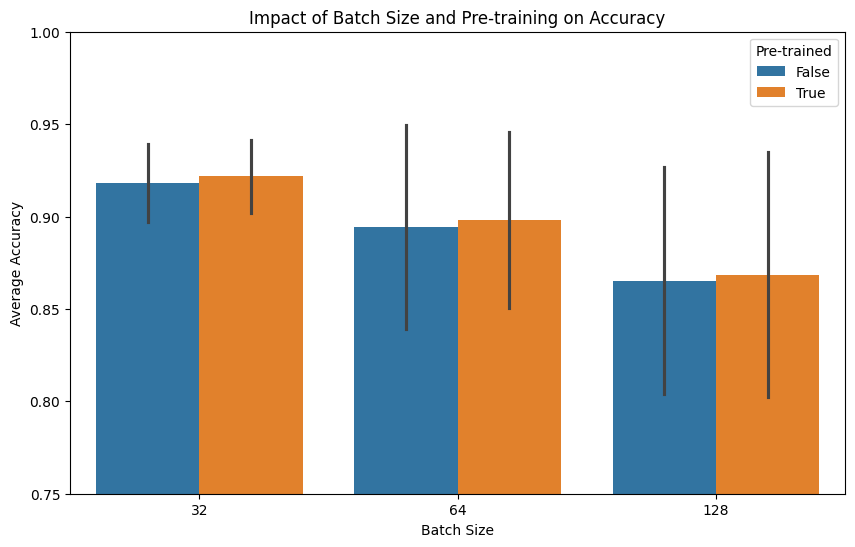

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot with error bars, grouped by pre-training
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='batch_size', y='accuracy', hue='pre_trained', data=results_df, errorbar='sd')
plt.ylim(0.75, 1.0)
plt.xlabel('Batch Size')
plt.ylabel('Average Accuracy')
plt.title('Impact of Batch Size and Pre-training on Accuracy')
plt.legend(title="Pre-trained")
plt.show()

## **Training Loss Against Epochs:**

Training loss is a measure of how well your model is fitting the training data. It represents the difference between the model's predictions and the actual target values. A lower training loss generally indicates that the model is learning and improving its ability to predict the correct output.

**Relationship with Epochs:**

- **General Trend:** As the number of epochs increases, the training loss typically decreases. This is because the model has more opportunities to adjust its weights and biases to better fit the training data.
- **Convergence:** Ideally, the training loss will gradually decrease and eventually plateau, indicating that the model has converged and further training might not lead to significant improvements.
- **Overfitting:** If the training loss continues to decrease significantly while the validation loss starts to increase, it might be a sign of overfitting. Overfitting occurs when the model learns the training data too well and starts to memorize it, leading to poor performance on unseen data.


**In this project, experimentation shows this relationship, tending to a stable point. Overall all models show decreased loss with increasing epochs, highlighting the models increased ability to fit to the data with each epoch. The plot also suggests that all the models tested would not be prone to significant overfitting, however only the `epoch=20` begin to converge to stability.**

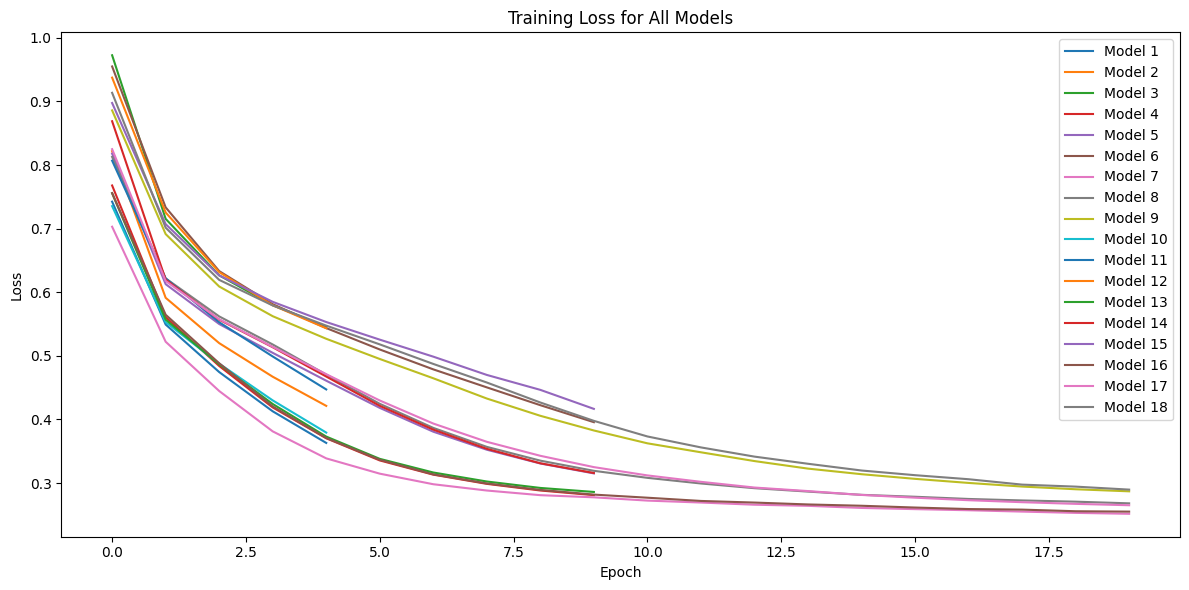

In [17]:
# --- Loss Plot ---
fig1, ax1 = plt.subplots(figsize=(12, 6))
for i, result in enumerate(results):
    ax1.plot(result['train_losses'], label=f"Model {i+1}", color=f'C{i}')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss for All Models")
ax1.legend()
plt.tight_layout()
plt.show()

## **Accuracy Against Epochs:**

Accuracy is a common metric used to evaluate the performance of a classification model. It represents the percentage of correctly classified instances in a dataset. Higher accuracy indicates better model performance.

**Relationship with Epochs:**

- **General Trend:** As the number of epochs increases, the accuracy on the training set typically increases. This is because the model is learning to make better predictions, with each epoch, as it sees more data and updates its weights.
- **Early Stopping:** Monitoring the accuracy helps decide when to stop training to prevent overfitting. You might stop training when the accuracy starts to decrease or stops improving significantly.

**In this project, all models show increasing prediction accuracy with increasing epochs. The higher epoch models also converge to a maximum accuracy without decreasing, aslo suggesting minimal overfitting.**

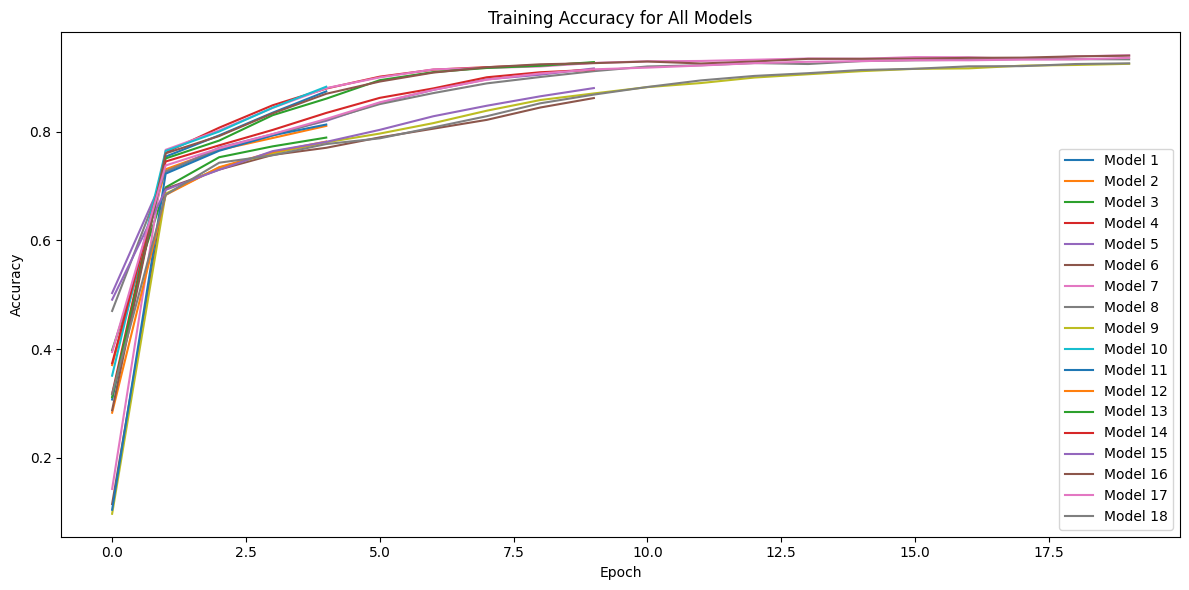

In [9]:
# --- Accuracy Plot ---
fig2, ax2 = plt.subplots(figsize=(12, 6))
for i, result in enumerate(results):
    ax2.plot(result['train_accuracies'], label=f"Model {i+1}", color=f'C{i}')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training Accuracy for All Models")
ax2.legend()
plt.tight_layout()
plt.show()

## Accuracy Against Final Loss
By examining the relationship between the final training loss and the achieved accuracy, we can draw conclusions about the overall performance and convergence of the models under different experimental settings. This analysis can ultimately select the most suitable model for the given classification task.

**Key Observations:**

* **General Trend:** The graph generally shows a negative correlation between accuracy and final loss. This is expected, as models with lower final loss values tend to have higher accuracy, indicating better performance.
* **Model Comparison:** The plot allows us to visually compare the performance of different models. Models clustered towards the top left corner (low loss, high accuracy) represent the best-performing models.

**In this project, we see a clearly see a negative correlation between accuracy and final loss, with model 16 consistantly the best performing. The lower loss cluster in the top left indicates the high epoch and low batch size models are learning and fitting the training data most effectivley.**


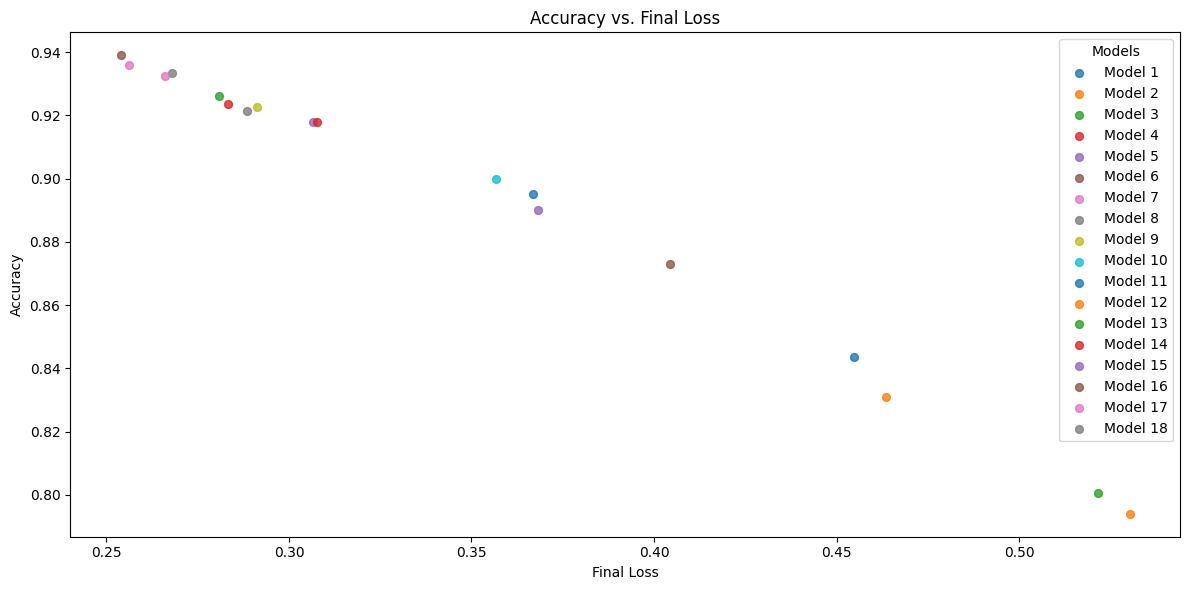

In [10]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
for i, result in enumerate(results):
    final_loss = results_df.loc[i, 'final_loss']  # Get final_loss from results_df
    ax.scatter(final_loss, result['accuracy'], s=32, alpha=.8, label=f"Model {i+1}")

ax.set_xlabel("Final Loss")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs. Final Loss")
# Remove this line to keep the box:
# ax.spines[['top', 'right']].set_visible(False)
ax.legend(title="Models", loc="upper right")

plt.tight_layout()
plt.show()

## Conclusion

This experiment investigated the impact of batch size on the performance of a neural network for classifying astronomical objects using the SDSS DR14 dataset. We trained and evaluated models with different batch sizes (32, 64, 128) while keeping other hyperparameters constant.

**Impact of Batch Size on Loss:**

- **General Trend:** The training loss generally decreased over epochs for all batch sizes, indicating that the models were learning from the data.
- **Batch Size Comparison:**
    - Models with smaller batch sizes (e.g., 32) tended to have more fluctuations in their loss curves compared to models with larger batch sizes (e.g., 128).
    - This is expected as smaller batches provide more frequent updates to the model's weights, leading to potentially more noise in the loss.
    - Larger batch sizes, while providing smoother loss curves, might take longer to converge.
- **Optimal Batch Size:** Based on the loss curves, a batch size of **64** seems to provide a good balance between convergence speed and stability, having the lowest loss and smooth curve.


**Impact of Batch Size on Accuracy:**

- **General Trend:** The training accuracy generally increased over epochs for all batch sizes, suggesting that the models were improving their ability to classify astronomical objects.
- **Batch Size Comparison:**
    - Models with smaller batch sizes might show slightly faster initial accuracy improvements, but larger batch sizes tend to catch up and sometimes achieve higher final accuracies.
    - This could be attributed to the fact that larger batches provide a more representative sample of the data for each weight update.
- **Optimal Batch Size:** In terms of accuracy, a batch size of **64** appears to be the most effective for this classification task, showing a high final accuracy.


**Overall Conclusions:**

- **Trade-offs:** There's a trade-off between convergence speed, stability, and final performance when choosing the batch size.
- **Recommendation:** For this specific dataset and model architecture, a batch size of **64** seems to provide a good balance between these factors, achieving low loss and high accuracy.
- **Further Investigation:** Further experiments with different learning rates and model architectures could be conducted to refine the optimal batch size and further improve the model's performance.

Running experiment: Pre-trained=False, Epochs=5, Batch Size=32
Epoch 1/5, Loss: 0.7333, Train Accuracy: 0.3301
Epoch 2/5, Loss: 0.5469, Train Accuracy: 0.7576
Epoch 3/5, Loss: 0.4825, Train Accuracy: 0.7905
Epoch 4/5, Loss: 0.4220, Train Accuracy: 0.8290
Epoch 5/5, Loss: 0.3712, Train Accuracy: 0.8726
Accuracy: 0.89
              precision    recall  f1-score   support

      GALAXY       0.92      0.88      0.90       996
         QSO       0.91      0.85      0.88       190
        STAR       0.85      0.91      0.88       814

    accuracy                           0.89      2000
   macro avg       0.89      0.88      0.89      2000
weighted avg       0.89      0.89      0.89      2000



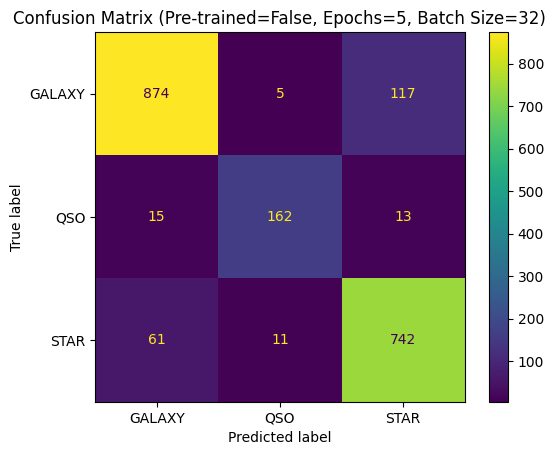

Running experiment: Pre-trained=False, Epochs=5, Batch Size=64
Epoch 1/5, Loss: 0.8328, Train Accuracy: 0.3040
Epoch 2/5, Loss: 0.6096, Train Accuracy: 0.7281
Epoch 3/5, Loss: 0.5411, Train Accuracy: 0.7658


KeyboardInterrupt: 

In [11]:
#%
# %% [markdown]
# ## 1. Data Loading and Preprocessing

# %%
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load data from Google Drive (replace with your own link)
url = "https://drive.google.com/uc?id=1Pfii448H__H0qa644YhTKUG68Z8VmxLv"
data = pd.read_csv(url)

# Select features and target
features = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z']
target = 'class'
X = data[features]
Y = data[target]

# Encode target labels
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

# Normalise features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

# Create DataLoaders
batch_size = 64  # You'll vary this later
train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=batch_size, shuffle=False)

# %% [markdown]
# ## 2. Model Definition

# %%
class SDSSClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, pre_trained=False):
        super(SDSSClassifier, self).__init__()
        self.pre_trained = pre_trained

        if pre_trained:
            # Load pre-trained model (e.g., ResNet18)
            self.features = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
            # Modify final layer to match your output dimension
            num_ftrs = self.features.fc.in_features
            self.features.fc = nn.Linear(num_ftrs, output_dim)
            # Add a layer to reshape the input for ResNet18
            self.reshape_layer = nn.Sequential(
                nn.Linear(input_dim, 224*224*3),  # Reshape to a compatible size for ResNet18
                nn.Unflatten(1, (3, 224, 224)) # Reshape to [channels, height, width]
            )

        else:
            # Define your custom model architecture
            self.fc = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim)
            )

    def forward(self, x):
        if self.pre_trained:
            # Reshape the input before passing it to ResNet18
            x = self.reshape_layer(x)
            return self.features(x)
        else:
            return self.fc(x)

# %% [markdown]
# ## 3. Training and Evaluation

# %%
def evaluate(model, data_loader): # Define the evaluate function here
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

def train_and_evaluate(model, train_loader, test_loader, num_epochs, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        # Calculate training accuracy for this epoch
        train_accuracy = evaluate(model, train_loader)  # Assuming you have an 'evaluate' function
        train_accuracies.append(train_accuracy)

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))  # Store average loss for the epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.2f}")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

    # Create and display confusion matrix
    title = f"Confusion Matrix (Pre-trained={pre_trained}, Epochs={num_epochs}, Batch Size={batch_size})"  # Create title
    cm = ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, display_labels=label_encoder.classes_)
    plt.title(title)  # Set the title
    plt.show()

    return accuracy, train_losses, train_accuracies  # Return accuracy, losses, and accuracies

# %% [markdown]
# ## 4. Experimentation

# %%
# Experiment with different settings
pre_trained_options = [False, True]  # With and without pre-training
epoch_options = [5, 10, 20]
batch_size_options = [32, 64, 128]

results = []

for pre_trained in pre_trained_options:
    for num_epochs in epoch_options:
        for batch_size in batch_size_options:
            print(f"Running experiment: Pre-trained={pre_trained}, Epochs={num_epochs}, Batch Size={batch_size}")

            # Create DataLoader with current batch size
            train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=batch_size, shuffle=False)

            # Instantiate and train the model
            input_dim = X_train.shape[1]
            hidden_dim = 64  # Adjust if needed
            output_dim = len(label_encoder.classes_)
            model = SDSSClassifier(input_dim, hidden_dim, output_dim, pre_trained=False)
            accuracy, train_losses, train_accuracies = train_and_evaluate(model, train_loader, test_loader, num_epochs)

            # Save the model's state dictionary
            torch.save(model.state_dict(), f"model_{pre_trained}_{num_epochs}_{batch_size}.pth")

            results.append({
                'pre_trained': pre_trained,
                'epochs': num_epochs,
                'batch_size': batch_size,
                'accuracy': accuracy,
                'train_losses': train_losses,  # Store losses
                'train_accuracies': train_accuracies  # Store accuracies
            })

# %% [markdown]
# ## 5. Results Analysis